## Select data to load based on keywords in experiment name

In [ ]:
import pandas as pd
import os

logs_dir = "logs"
logs_dir = "benchmark_results"

experiment_name = "experiment_1percent"
# experiment_name = "experiment_good"
# experiment_name = "experiment_small"
dataset_name = "diabetes"
# dataset_name = "kaggle_hf"

results_file = "per_center_results.csv"

keywords = [
    experiment_name,
    dataset_name,
    # "logistic_regression",
    # "forest",
    #   "c10"
    #   "a0.7"
    #   "a1.0"
      "aNone"
    ]

# Normalization experiment
experiment_name = "normalization"
logs_dir = "benchmark_results_normalization"
model_names = ["logistic_regression"]
datasets = ["diabetes"]
num_clients = [10]
dirichlet_alpha = ["None"]
data_normalization = ["global", "local", None]
keywords = [experiment_name]

def load_data(logs_dir, experiment_name, keywords, results_file="per_center_results.csv"):
    data = {}

    # iterate over all directories in logs_dir with names containing all the keywords
    dirs = [d for d in os.listdir(logs_dir) if all(keyword in d for keyword in keywords)]
    for d in dirs:    
        model_name = d
        model_name = model_name.replace(experiment_name+"_", "")
        # model_name = model_name.replace(experiment_name+"_"+dataset_name+"_", "")
        model_name = model_name.replace("_", " ")
        model_name = model_name.title()
        model_name = model_name.replace("none", "N")
        # Find position of _c keyword
        pos = model_name.find(" C")
        # if pos != -1:
        #     if not model_name[pos+3].isdigit():
        #         model_name = model_name[:pos+2] + "0" + model_name[pos+2:]
        #remove non-capital letters
        # model_name = ''.join(c for c in model_name if c.isupper() or c == ' ' or c.isdigit())

        full_path = os.path.join(logs_dir, d)
        metrics_file = os.path.join(full_path, results_file)
        if os.path.isfile(metrics_file):
            df = pd.read_csv(metrics_file)
            data[model_name] = df

    print("Found ", len(data), " experiments")

    # Sort data by model_name
    data = dict(sorted(data.items()))

    # for model_name, df in data.items():
        # print(model_name)
    
    return data

### Print metric values

In [5]:
metric = "balanced_accuracy"
# metric = "accuracy"
results = []
#print average metric across all centers for each model
for model_name, df in data.items():
    #weighted average by number of samples in each center
    total_samples = df["n samples"].sum()
    weighted_sum = (df[metric] * df["n samples"]).sum()
    avg_metric = weighted_sum / total_samples
    results.append(f"{model_name}: {avg_metric:.4f}")
    # print(f"{model_name}: {avg_metric:.4f}")

# Sort results alphabetically by model name
results.sort()
for result in results:
    print(result)

Logistic Regression C10 AN NormN FeatN: 0.6632
Logistic Regression C10 AN Normglobal FeatN: 0.7546
Logistic Regression C10 AN Normlocal FeatN: 0.7586


# Bar plot for all imported models

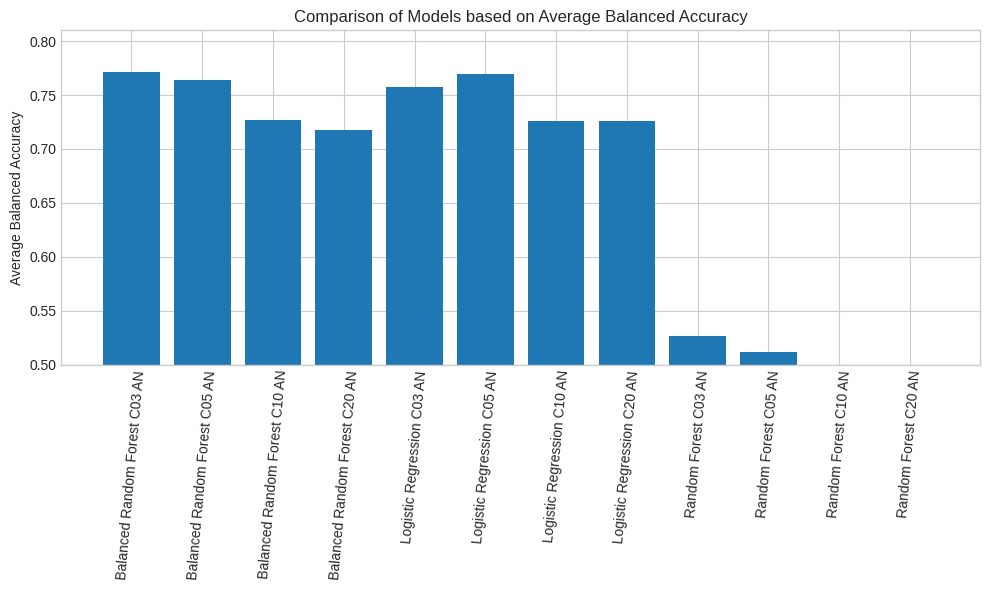

In [49]:
# Make a bar plot comparing the models based on the average metric
import matplotlib.pyplot as plt
model_names = []
avg_metrics = []
for model_name, df in data.items():
    total_samples = df["n samples"].sum()
    weighted_sum = (df[metric] * df["n samples"]).sum()
    avg_metric = weighted_sum / total_samples
    
    model_names.append(model_name)
    avg_metrics.append(avg_metric)

# Sort models by names
model_names, avg_metrics = zip(*sorted(zip(model_names, avg_metrics)))

plt.figure(figsize=(10, 6))
plt.bar(model_names, avg_metrics)
plt.ylabel(f'Average {metric.replace("_", " ").title()}')
plt.title(f'Comparison of Models based on Average {metric.replace("_", " ").title()}')
#start y-axis from 0.5
plt.ylim(bottom=0.5)
plt.xticks(rotation=85)
plt.tight_layout()
plt.show()  



# Box Plots: Number of Clients 


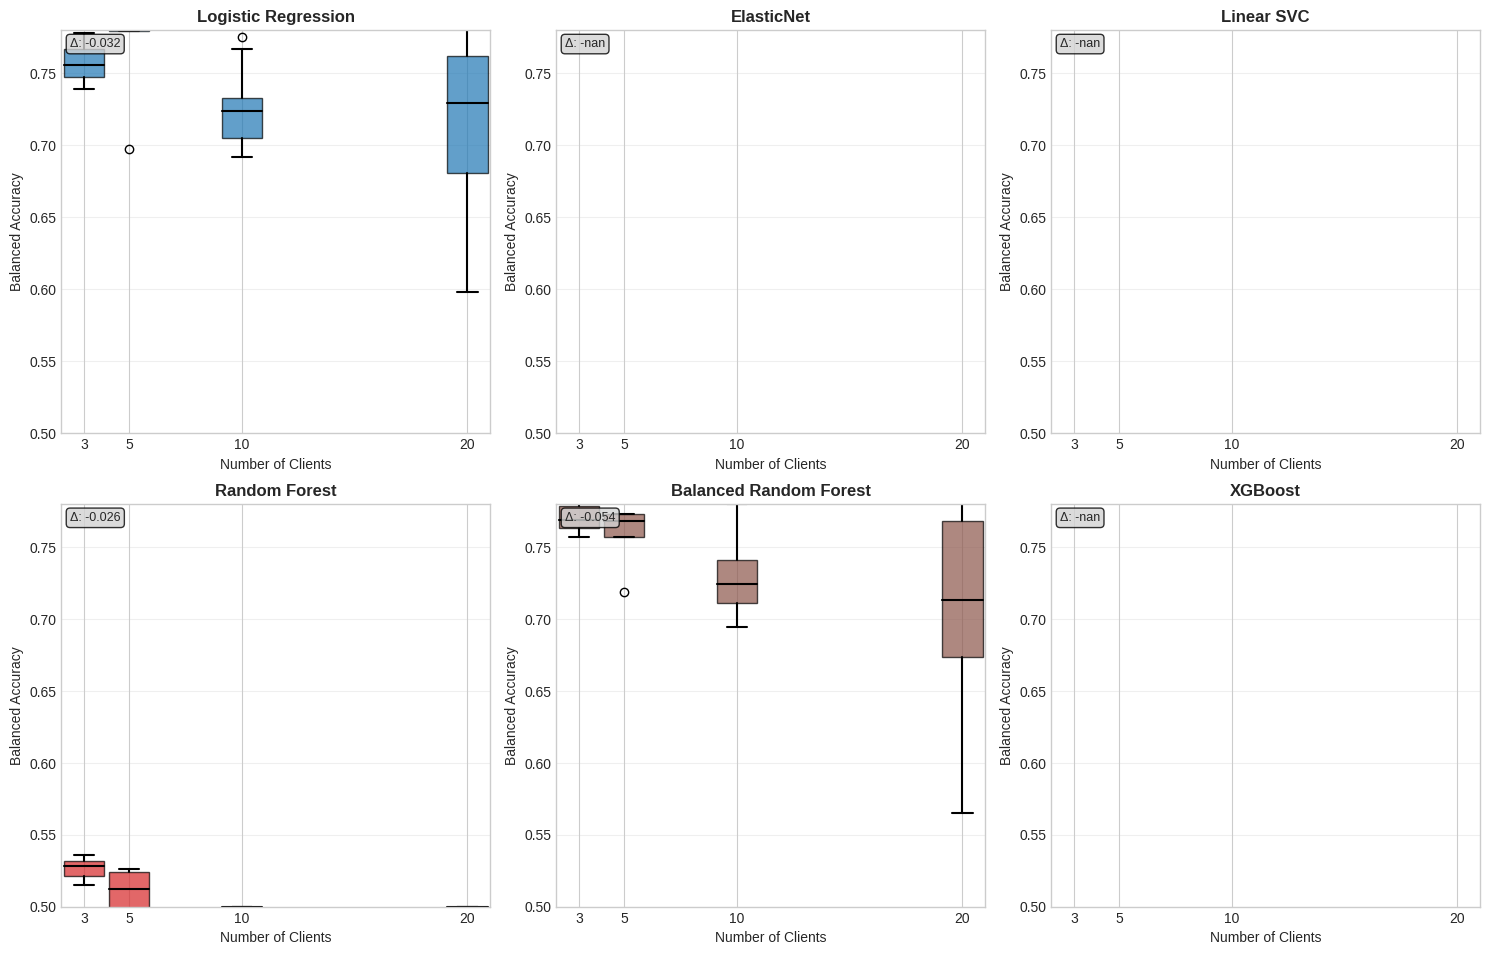

Federated Learning Benchmark Summary - Box Plot Analysis

Logistic Regression:
----------------------------------------
   3 clients: 0.7577 ± 0.0196 [0.7390, 0.7780]
   5 clients: 0.7694 ± 0.0413 [0.6970, 0.7960]
  10 clients: 0.7258 ± 0.0275 [0.6920, 0.7750]
  20 clients: 0.7255 ± 0.0637 [0.5980, 0.8580]
  Performance degradation (3→20 clients): 4.25%

ElasticNet:
----------------------------------------
   3 clients: nan ± nan [nan, nan]
   5 clients: nan ± nan [nan, nan]
  10 clients: nan ± nan [nan, nan]
  20 clients: nan ± nan [nan, nan]
  Performance degradation (3→20 clients): nan%

Linear SVC:
----------------------------------------
   3 clients: nan ± nan [nan, nan]
   5 clients: nan ± nan [nan, nan]
  10 clients: nan ± nan [nan, nan]
  20 clients: nan ± nan [nan, nan]
  Performance degradation (3→20 clients): nan%

Random Forest:
----------------------------------------
   3 clients: 0.5263 ± 0.0106 [0.5150, 0.5360]
   5 clients: 0.5116 ± 0.0135 [0.4980, 0.5260]
  10 client

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score

# Set style for academic paper
plt.style.use('seaborn-v0_8-whitegrid')
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

# Define models and client configurations (performance decreases with more clients)
models = ['Logistic Regression', 'ElasticNet', 'Linear SVC', 'Random Forest', 'Balanced Random Forest', 'XGBoost']
clients = [3, 5, 10, 20]  # Only these client numbers
# clients = [3, 5, 10]  # Only these client numbers

extracted_data = []
metric = "balanced_accuracy"
for model_name, df in data.items():
    model = model_name.split(" C")[0]
    if model == "Elastic Net":
        model = "ElasticNet"
    if model == "Lsvc":
        model = "Linear SVC"
    num_clients = int(model_name.split(" C")[-1][:2])
    alpha = model_name.split(" A")[-1]
    metric_scores = df[metric].values
    for center, score in enumerate(metric_scores):
        extracted_data.append({
                'model': model,
                'run': center,  # Placeholder, as run info is not available
                'n_clients': num_clients,
                'alpha': alpha,
                metric: score
            })

# Convert to DataFrame
df = pd.DataFrame(extracted_data)

# print(df)

# Create 3x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Define colors for each model
colors = {
    'Logistic Regression': '#1f77b4',
    'ElasticNet': '#ff7f0e', 
    'Linear SVC': '#2ca02c',
    'Random Forest': '#d62728',
    'Balanced Random Forest': '#8c564b',
    'XGBoost': '#9467bd',
    'MLP': '#8c564b'
}

# Prepare data for boxplot
# boxplot_data = []
# client_labels = []
x_positions = clients

# for client_idx, client in enumerate(clients):
#     client_data = model_data[model_data['n_clients'] == client][metric]
#     if len(client_data) > 0:
#         boxplot_data.append(client_data)
#         # Use actual client number as x-position
#         client_labels.append(f'{client}')
    
# print(box_positions)
# x

# Plot box plots for each model in separate subplots
for i, model in enumerate(models):
    if i < len(axes):  # Ensure we don't exceed subplot count
        ax = axes[i]
        model_data = df[df['model'] == model]
        
        # Prepare data for boxplot
        boxplot_data = []
        client_labels = []
        box_positions = []

        for client_idx, client in enumerate(clients):
            client_data = model_data[model_data['n_clients'] == client][metric]
            boxplot_data.append(client_data)
            box_positions.append(x_positions[client_idx])
            client_labels.append(f'{client}')
        
        
        # print(f"Model: {model}")
        # print("Box data:", boxplot_data)
        
        
        # Create box plot with custom positions
        # Adjust width relative to the x-axis scale
        # Base width on the smallest gap between client numbers
        min_gap = min([x_positions[i+1] - x_positions[i] for i in range(len(x_positions)-1)])
        box_width = min_gap * 0.9  # Adjust this factor to control box width
        
        box_plots = ax.boxplot(boxplot_data, positions=box_positions, 
                              widths=box_width, patch_artist=True,
                              showmeans=False, 
                              meanprops={'marker':'o', 'markerfacecolor':'white', 
                                       'markeredgecolor':'black'})
        # Color the boxes
        for patch in box_plots['boxes']:
            patch.set_facecolor(colors[model])
            patch.set_alpha(0.7)
        
        # Customize box plot elements
        for element in ['whiskers', 'caps', 'medians']:
            for line in box_plots[element]:
                line.set_color('black')
                line.set_linewidth(1.5)

        # Set x-ticks to client numbers
        ax.set_xticks(box_positions)
        ax.set_xticklabels(client_labels)
        
        # Set subplot title and labels
        ax.set_title(f'{model}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Number of Clients', fontsize=10)
        metric_formatted = metric.replace("_", " ").title()
        ax.set_ylabel(metric_formatted, fontsize=10)
        
        # Set consistent y-axis across all subplots
        # ax.set_ylim(0.5, 0.78)
        ax.set_ylim(0.4, 0.85)

        # Set x-axis limits with some padding
        ax.set_xlim(min(box_positions) - min_gap * 0.5, 
                   max(box_positions) + min_gap * 0.5)
        
        # Add grid
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add trend annotation
        means = [np.mean(client_data) for client_data in boxplot_data]
        trend = means[0] - means[-1]  # Performance drop from 3 to 20 clients
        
        # Add performance degradation annotation
        ax.text(0.02, 0.98, f'Δ: -{trend:.3f}', transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# Remove empty subplot if we have 6 models in 3x3 grid
if len(models) < len(axes):
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

# Add overall title
# fig.suptitle('Federated Learning Benchmark: Model Performance Distribution vs Number of Clients\n'
            #  'Box Plots Showing Performance Degradation with Increasing Clients', 
            #  fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Print detailed statistics for the paper
print("Federated Learning Benchmark Summary - Box Plot Analysis")
print("=" * 80)

for model in models:
    print(f"\n{model}:")
    print("-" * 40)
    model_data = df[df['model'] == model]
    
    for client in clients:
        client_data = model_data[model_data['n_clients'] == client][metric]
        mean_auc = client_data.mean()
        std_auc = client_data.std()
        min_auc = client_data.min()
        max_auc = client_data.max()
        
        print(f"  {client:2d} clients: {mean_auc:.4f} ± {std_auc:.4f} "
              f"[{min_auc:.4f}, {max_auc:.4f}]")
    
    # Calculate overall degradation
    perf_3 = model_data[model_data['n_clients'] == 3][metric].mean()
    perf_20 = model_data[model_data['n_clients'] == 20][metric].mean()
    degradation = ((perf_3 - perf_20) / perf_3) * 100
    print(f"  Performance degradation (3→20 clients): {degradation:.2f}%")

# Comparative analysis
print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS:")
print("=" * 80)

# Find best performing model at each client count
for client in clients:
    client_data = df[df['n_clients'] == client]
    best_model = None
    best_auc = 0
    
    for model in models:
        model_auc = client_data[client_data['model'] == model][metric].mean()
        if model_auc > best_auc:
            best_auc = model_auc
            best_model = model

    print(f"Best at {client:2d} clients: {best_model} ({metric}: {best_auc:.4f})")

# Overall best model
overall_means = df.groupby('model')[metric].mean()
best_overall_model = overall_means.idxmax()
best_overall_auc = overall_means.max()

print(f"\nOverall best model: {best_overall_model} (Avg {metric}: {best_overall_auc:.4f})")

# Table: Normalization impact

In [ ]:
# Normalization experiment
experiment_name = "normalization"
logs_dir = "benchmark_results_normalization"
model_names = ["logistic_regression"]
datasets = ["diabetes"]
num_clients = [10]
dirichlet_alpha = ["None"]
data_normalization = ["global", "local", None]
keywords = [experiment_name]
data = load_data(logs_dir, experiment_name, keywords, results_file="per_center_results.csv")

# Write a code to extract the following metrics, calculate weighted averages and standard deviations and create a table with rows as models and columns as metrics in latex format
metrics_to_extract = ["balanced_accuracy", "auroc"]
table_data = {}
for model_name, df in data.items():
    # model = model_name.split(" Norm")[1]
    model = model_name
    total_samples = df["n samples"].sum()
    table_data[model] = {}
    for metric in metrics_to_extract:
        weighted_sum = (df[metric] * df["n samples"]).sum()
        avg_metric = weighted_sum / total_samples
        std_metric = ( ((df[metric] - avg_metric)**2 * df["n samples"]).sum() / total_samples )**0.5
        table_data[model][metric] = (avg_metric, std_metric)

# Print nicely formatted table
print("\nWeighted Average Metrics Table:\n")
header = "Model".ljust(30)
for metric in metrics_to_extract:
    header += f"{metric.replace('_', ' ').title():>30}"
print(header)
for model, metrics in table_data.items():
    row = model.ljust(30)
    for metric in metrics_to_extract:
        avg, std = metrics[metric]
        row += f"{avg:.3f} ± {std:.3f}".rjust(30)
    print(row)


# Create latex table
latex_table = "\\begin{tabular}{l" + "c" * len(metrics_to_extract) + "}\n"
latex_table += "Model"
for metric in metrics_to_extract:
    latex_table += f" & {metric.replace('_', ' ').title()}"
latex_table += " \\\\\n\\hline\n"
for model, metrics in table_data.items():
    latex_table += model
    for metric in metrics_to_extract:
        avg, std = metrics[metric]
        latex_table += f" & {avg:.3f} $\\pm$ {std:.3f}"
    latex_table += " \\\\\n"
latex_table += "\\end{tabular}"
print("\nLaTeX Table:\n")
print(latex_table)



Weighted Average Metrics Table:

Model                                      Balanced Accuracy                         Auroc
Diabetes Logistic Regression C10 A0.7 NormN FeatN                 0.654 ± 0.021                 0.729 ± 0.034
Diabetes Logistic Regression C10 A0.7 Normglobal FeatN                 0.745 ± 0.041                 0.803 ± 0.049
Diabetes Logistic Regression C10 A0.7 Normlocal FeatN                 0.730 ± 0.024                 0.801 ± 0.056
Diabetes Logistic Regression C10 AN NormN FeatN                 0.665 ± 0.017                 0.725 ± 0.014
Diabetes Logistic Regression C10 AN Normglobal FeatN                 0.755 ± 0.011                 0.829 ± 0.009
Diabetes Logistic Regression C10 AN Normlocal FeatN                 0.759 ± 0.011                 0.830 ± 0.010
Ukbb Cvd Logistic Regression C10 A0.7 NormN FeatN                 0.515 ± 0.009                 0.529 ± 0.027
Ukbb Cvd Logistic Regression C10 A0.7 Normglobal FeatN                 0.742 ± 0.035         

# Table: Feature Selection

In [34]:
# Feature selection experiment
experiment_name = "feature_selection"
benchmark_dir = "benchmark_results_feature_selection"
model_names = ["balanced_random_forest"]
datasets = ["ukbb_cvd"]
num_clients = [5,10]
dirichlet_alpha = [0.7, None]
data_normalization = ["global"]
n_features = [10, 20, 35, 40, None]
keywords = [experiment_name]

data = load_data(benchmark_dir, experiment_name, keywords)
# Write a code to extract the following metrics, calculate weighted averages and standard deviations and create a table with rows as models and columns as metrics in latex format
metrics_to_extract = ["balanced_accuracy", "auroc", "round_time [s]"]
table_data = {}
for model_name, df in data.items():
    # model = model_name.split(" Norm")[1]
    model = model_name
    total_samples = df["n samples"].sum()
    table_data[model] = {}
    for metric in metrics_to_extract:
        weighted_sum = (df[metric] * df["n samples"]).sum()
        avg_metric = weighted_sum / total_samples
        std_metric = ( ((df[metric] - avg_metric)**2 * df["n samples"]).sum() / total_samples )**0.5
        table_data[model][metric] = (avg_metric, std_metric)

# Print nicely formatted table
print("\nWeighted Average Metrics Table:\n")
header = "Model".ljust(30)
for metric in metrics_to_extract:
    header += f"{metric.replace('_', ' ').title():>30}"
print(header)
for model, metrics in table_data.items():
    row = model.ljust(30)
    for metric in metrics_to_extract:
        avg, std = metrics[metric]
        row += f"{avg:.3f} ± {std:.3f}".rjust(30)
    print(row)


# Create latex table
latex_table = "\\begin{tabular}{l" + "c" * len(metrics_to_extract) + "}\n"
latex_table += "Model"
for metric in metrics_to_extract:
    latex_table += f" & {metric.replace('_', ' ').title()}"
latex_table += " \\\\\n\\hline\n"
for model, metrics in table_data.items():
    latex_table += model
    for metric in metrics_to_extract:
        avg, std = metrics[metric]
        latex_table += f" & {avg:.3f} $\\pm$ {std:.3f}"
    latex_table += " \\\\\n"
latex_table += "\\end{tabular}"
print("\nLaTeX Table:\n")
print(latex_table)


Found  6  experiments
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat10
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat20
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat35
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat40
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal FeatN
Ukbb Cvd Balanced Random Forest C5 AN Normglobal Feat10

Weighted Average Metrics Table:

Model                                      Balanced Accuracy                         Auroc                Round Time [S]
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat10                 0.757 ± 0.024                 0.818 ± 0.022                 0.966 ± 0.199
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat20                 0.742 ± 0.028                 0.823 ± 0.027                 1.032 ± 0.212
Ukbb Cvd Balanced Random Forest C5 A0.7 Normglobal Feat35                 0.750 ± 0.027                 0.825 ± 0.025                 1.098 ± 0.226
Ukbb Cvd Balanced Random Forest C5